# Libraries

In [18]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from transformers import GPT2Config, GPT2Tokenizer, GPT2ForSequenceClassification, BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from ml_things import plot_dict, plot_confusion_matrix

# Preprocessing

- <strong>count</strong>: number of CrowdFlower users who coded each tweet
- <strong>hate_speech</strong>: number of CF users who judged the tweet to be hate speech
- <strong>offensive_language</strong>: number of CF users who judged the tweet to be offensive
- <strong>neither</strong>: number of CF users who judged the tweet to be neither offensive nor non-offensive
- <strong>class</strong>: class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither
- <strong>tweet</strong>: text tweet

In [19]:
# Tensorboard initialization
writer = SummaryWriter(log_dir="./logs")

def parse_tweets_until_colon(data):
    parsed_tweets = []
    for tweet in data['tweet']:
        colon_index = tweet.find(':')
        if colon_index != -1:
            parsed_tweets.append(tweet[colon_index + 1:])
        else:
            parsed_tweets.append(tweet)
    return parsed_tweets

data = pd.read_csv('labeled_data.csv')
data = data.drop(columns='Unnamed: 0')
data['tweet'] = parse_tweets_until_colon(data)

data.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,As a woman you shouldn't complain about clean...
1,3,0,3,0,1,boy dats cold...tyga dwn bad for cuffin dat h...
2,3,0,3,0,1,You ever fuck a bitch and she start to cry? Y...
3,3,0,2,1,1,@viva_based she look like a tranny
4,6,0,6,0,1,The shit you hear about me might be true or i...


# Text cleaning

- <strong>Lowercasing</strong>: Convert all text to lowercase to ensure uniformity.
- <strong>Removing Punctuation</strong>: Eliminate punctuation marks as they often don't carry much meaning in NLP tasks.
- <strong>Removing Special Characters</strong>: Remove special characters, emojis, URLs, etc., which may not contribute to the task at hand.
- <strong>Removing Stopwords</strong>: Stopwords are common words (e.g., "the", "is", "and") that occur frequently but often carry little information. Removing them can reduce noise in the data.

In [20]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

def clean_text(data):
    cleaned_tweets = []
    for tweet in data:
        tweet = tweet.lower()  # Convert text to lowercase
        tweet = re.sub(r"[^\w\s]", "", tweet)  # Remove punctuation
        tweet = re.sub(r"\d+", "", tweet)  # Remove numbers
        tweet = re.sub(r"\s+", " ", tweet).strip()  # Remove extra whitespaces
        cleaned_tweets.append(tweet)
    return cleaned_tweets

def remove_stopwords(data):
    nostopwords_tweets = []
    for tweet in data:
        tokens = word_tokenize(tweet)  # Tokenize text
        stop_words = set(stopwords.words("english"))
        filtered_tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
        filtered_text = " ".join(filtered_tokens)  # Join tokens back into a string
        nostopwords_tweets.append(filtered_text)
    return nostopwords_tweets

def apply_stemming(data):
    stemmer = PorterStemmer()
    stemmed_tweets = []
    for tweet in data:
        tokens = word_tokenize(tweet)  # Tokenize text
        stemmed_tokens = [stemmer.stem(token) for token in tokens]  # Apply stemming
        stemmed_text = " ".join(stemmed_tokens)  # Join tokens back into a string
        stemmed_tweets.append(stemmed_text)
    return stemmed_tweets

def apply_lemmatization(data):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tweets = []
    for tweet in data:
        tokens = word_tokenize(tweet)  # Tokenize text
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Apply lemmatization
        lemmatized_text = " ".join(lemmatized_tokens)  # Join tokens back into a string
        lemmatized_tweets.append(lemmatized_text)
    return lemmatized_tweets

data["tweet"] = clean_text(data["tweet"])
data["tweet"] = remove_stopwords(data["tweet"])
data["tweet"] = apply_stemming(data["tweet"])
data["tweet"] = apply_lemmatization(data["tweet"])

data.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eddy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eddy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Eddy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,woman shouldnt complain clean hous amp man alw...
1,3,0,3,0,1,boy dat coldtyga dwn bad cuffin dat hoe st place
2,3,0,3,0,1,ever fuck bitch start cri confus shit
3,3,0,2,1,1,viva_bas look like tranni
4,6,0,6,0,1,shit hear might true might faker bitch told ya


## Split training/test set

- 80% → training set
- 20% → test set

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data["tweet"], data["class"], test_size=0.2, random_state=1)

# GPT-2

The OpenAI GPT-2 (Generative Pre-Trained Transformer 2) is a transfomer-based language model. It's a standard model for NLP tasks.

Training GPT-2 model...


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.4370136004380229
Epoch 2: Average Loss: 0.2897585100997971
Epoch 3: Average Loss: 0.20482932436322157
Epoch 4: Average Loss: 0.1302792085616025
GPT-2 training complete.
GPT-2 Accuracy: 0.8718983256001613


C:\Users\Eddy\AppData\Roaming\Python\Python312\site-packages\ml_things\plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


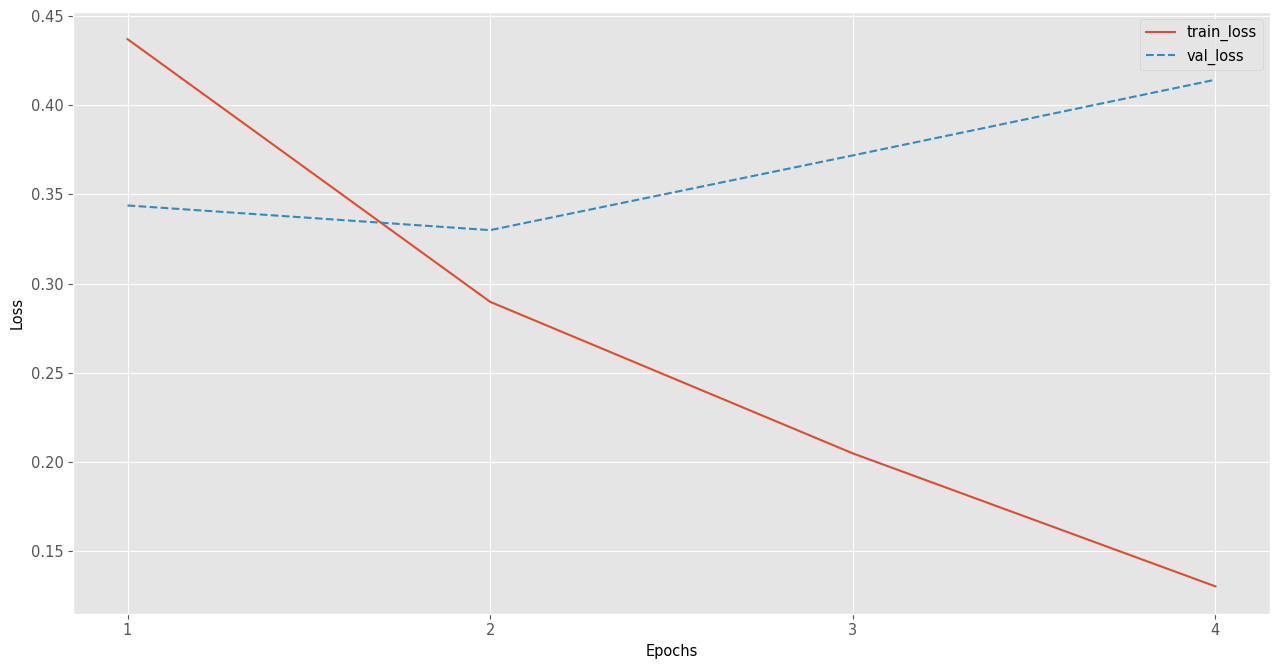

C:\Users\Eddy\AppData\Roaming\Python\Python312\site-packages\ml_things\plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


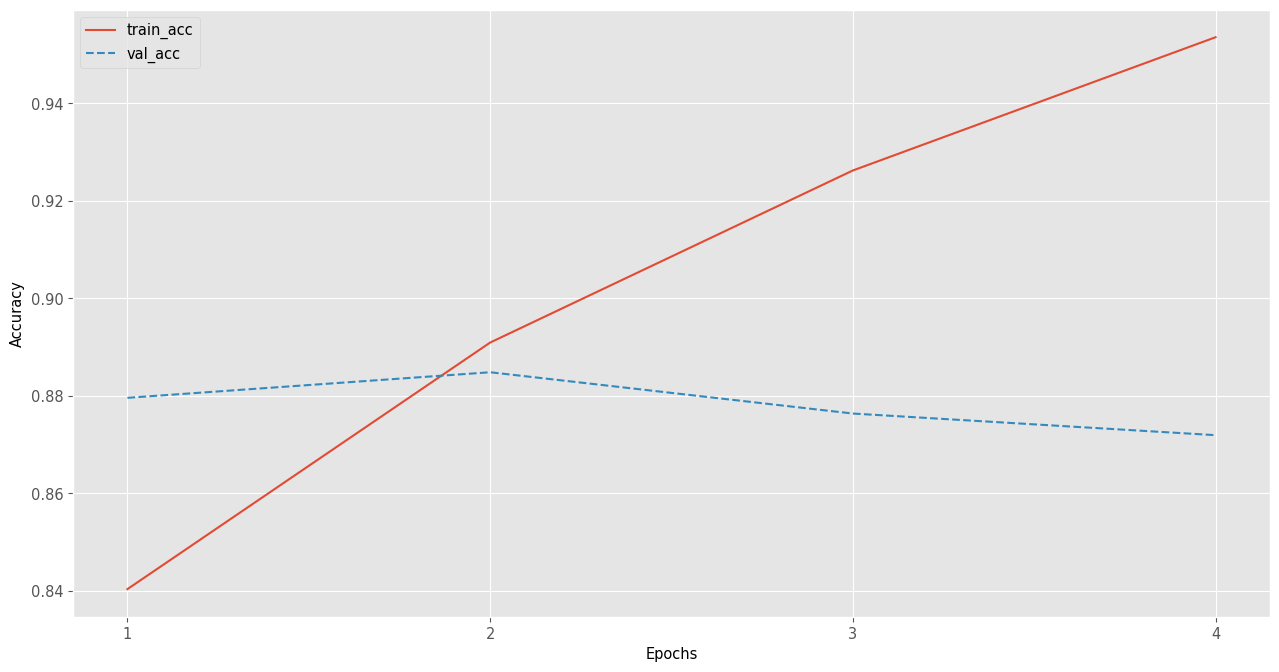

Classification Report:
              precision    recall  f1-score   support

     class 0       0.42      0.26      0.32       296
     class 1       0.92      0.93      0.92      3853
     class 2       0.75      0.84      0.79       808

    accuracy                           0.87      4957
   macro avg       0.70      0.67      0.68      4957
weighted avg       0.86      0.87      0.87      4957

Normalized confusion matrix


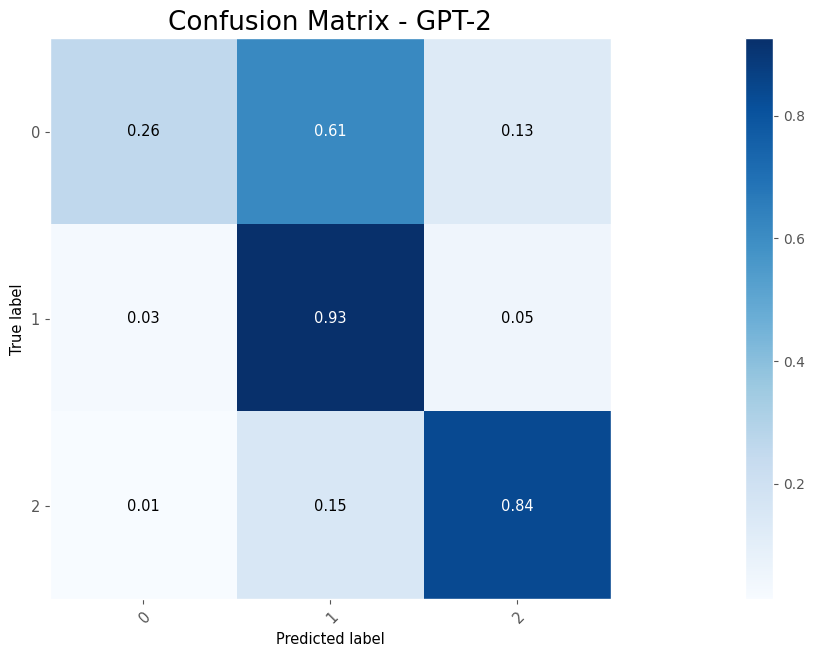

array([[0.25675676, 0.61486486, 0.12837838],
       [0.02517519, 0.92655074, 0.04827407],
       [0.01113861, 0.15222772, 0.83663366]])

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token  # Set padding token to eos_token

max_length = 32
tokenized_texts_train = tokenizer_gpt2(list(X_train), padding=True, truncation=True, max_length=max_length, return_tensors='pt')
tokenized_texts_test = tokenizer_gpt2(list(X_test), padding=True, truncation=True, max_length=max_length, return_tensors='pt')

# Save tokenized data to disk
torch.save(tokenized_texts_train, 'tokenized_texts_train_gpt2.pth')  
torch.save(tokenized_texts_test, 'tokenized_texts_test_gpt2.pth')

labels_train = torch.tensor(list(y_train)).to(device)
labels_test = torch.tensor(list(y_test)).to(device)

train_dataset_gpt2 = TensorDataset(tokenized_texts_train.input_ids, tokenized_texts_train.attention_mask, labels_train)
test_dataset_gpt2 = TensorDataset(tokenized_texts_test.input_ids, tokenized_texts_test.attention_mask, labels_test)

# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 60

train_loader_gpt2 = DataLoader(train_dataset_gpt2, batch_size=batch_size, shuffle=True)
test_loader_gpt2 = DataLoader(test_dataset_gpt2, batch_size=batch_size, shuffle=False)

model_config_gpt2 = GPT2Config.from_pretrained('gpt2', num_labels=3, pad_token_id=tokenizer_gpt2.pad_token_id)
model_gpt2 = GPT2ForSequenceClassification(model_config_gpt2).to(device)
model_gpt2.resize_token_embeddings(len(tokenizer_gpt2))

# model_gpt2.load_state_dict(torch.load('gpt2_model.pth'))  # Load pre-trained GPT-2 model from disk
model_gpt2.eval()

optimize_gpt2 = AdamW(model_gpt2.parameters(), lr=5e-5, no_deprecation_warning=True)

# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4).
epochs = 4
tokenized_texts_train = torch.load('tokenized_texts_train_gpt2.pth')  # Load pre-processed tokenized data from disk
tokenized_texts_test = torch.load('tokenized_texts_test_gpt2.pth')

all_loss_gpt2 = {'train_loss':[], 'val_loss':[]}
all_acc_gpt2 = {'train_acc':[], 'val_acc':[]}

print("Training GPT-2 model...")
model_gpt2.train()
for epoch in tqdm(range(epochs)):
    total_loss = 0
    total_correct_train = 0
    total_samples_train = 0
    for batch in train_loader_gpt2:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimize_gpt2.zero_grad()

        outputs = model_gpt2(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        writer.add_scalar("Loss/train_gpt2", loss, epoch)

        total_loss += loss.item()

        _, predicted_train = torch.max(outputs.logits, 1)
        total_samples_train += labels.size(0)
        total_correct_train += (predicted_train == labels).sum().item()

        loss.backward()
        optimize_gpt2.step()
    print(f'Epoch {epoch + 1}: Average Loss: {total_loss / len(train_loader_gpt2)}')
    all_loss_gpt2['train_loss'].append(total_loss / len(train_loader_gpt2))
    all_acc_gpt2['train_acc'].append(total_correct_train / total_samples_train)
    model_gpt2.eval()
    total_val_loss = 0
    total_correct_val = 0
    total_samples_val = 0
    with torch.no_grad():
        for batch in test_loader_gpt2:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model_gpt2(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss = outputs.loss

            total_val_loss += val_loss.item()

            _, predicted_val = torch.max(outputs.logits, 1)
            total_samples_val += labels.size(0)
            total_correct_val += (predicted_val == labels).sum().item()
    
    all_loss_gpt2['val_loss'].append(total_val_loss / len(test_loader_gpt2))
    all_acc_gpt2['val_acc'].append(total_correct_val / total_samples_val)
    writer.add_scalar("Loss/val_gpt2", total_val_loss / len(test_loader_gpt2), epoch)

    torch.save(model_gpt2.state_dict(), 'gpt2_model.pth') # saving gpt-2 model
    writer.flush()

print("GPT-2 training complete.")
model_gpt2.eval()
predicted_labels_gpt2 = []
true_labels_gpt2 = []

with torch.no_grad():
    for batch in test_loader_gpt2:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model_gpt2(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        predicted_labels_gpt2.extend(torch.argmax(logits, axis=1).tolist())
        true_labels_gpt2.extend(labels.tolist())

accuracy_gpt2 = accuracy_score(true_labels_gpt2, predicted_labels_gpt2)
print(f'GPT-2 Accuracy: {accuracy_gpt2}')

plot_dict(all_loss_gpt2, use_xlabel='Epochs', use_ylabel='Loss', use_linestyles=['-', '--'])
plot_dict(all_acc_gpt2, use_xlabel='Epochs', use_ylabel='Accuracy', use_linestyles=['-', '--'])

print("Classification Report:")
print(classification_report(true_labels_gpt2, predicted_labels_gpt2, target_names=['class 0', 'class 1', 'class 2']))

plot_confusion_matrix(y_true=true_labels_gpt2, y_pred=predicted_labels_gpt2, classes=[0, 1, 2], normalize=True, magnify=0.1, use_title="Confusion Matrix - GPT-2")

# BERT

BERT (Bidirectional Encoder Representations from Transformers) was developed by Google researchers.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT model...


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: Average Loss: 0.3508228725356998
Epoch 2: Average Loss: 0.2611265895364868
Epoch 3: Average Loss: 0.2024569479112719
Epoch 4: Average Loss: 0.13388629680291222
BERT training complete.
BERT Accuracy: 0.8825902763768408


C:\Users\Eddy\AppData\Roaming\Python\Python312\site-packages\ml_things\plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


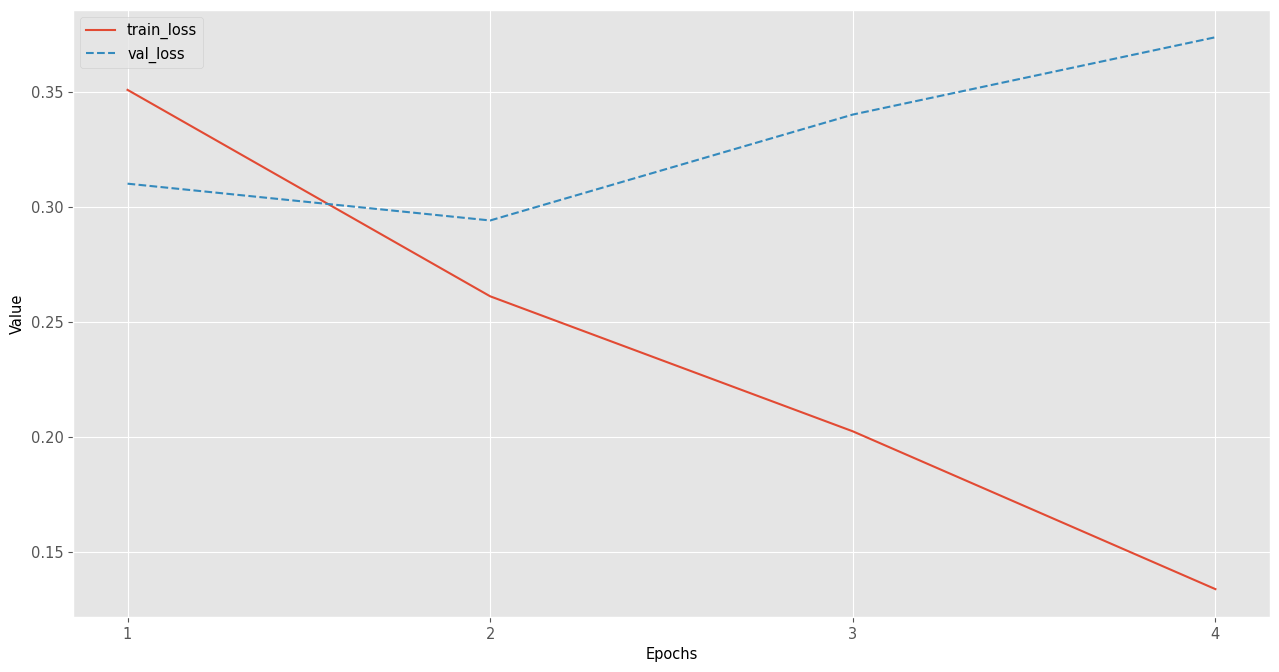

C:\Users\Eddy\AppData\Roaming\Python\Python312\site-packages\ml_things\plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


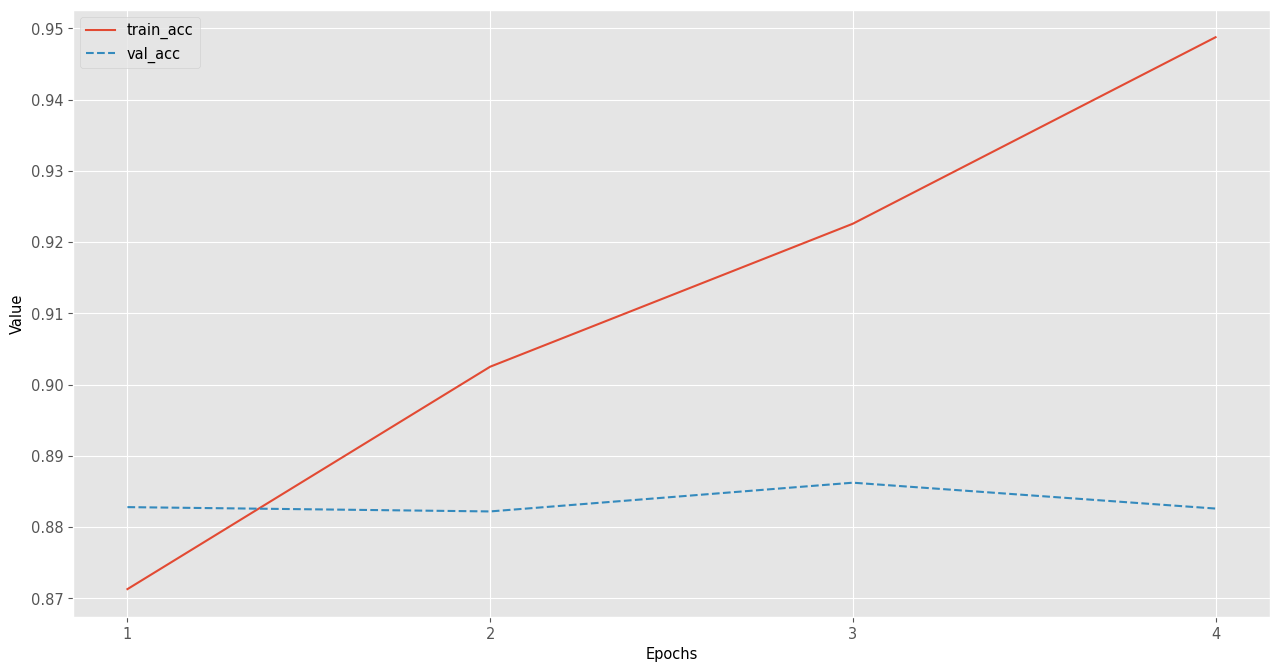

Classification Report:
              precision    recall  f1-score   support

     class 0       0.45      0.27      0.34       296
     class 1       0.92      0.95      0.93      3853
     class 2       0.81      0.81      0.81       808

    accuracy                           0.88      4957
   macro avg       0.73      0.67      0.69      4957
weighted avg       0.87      0.88      0.88      4957

Normalized confusion matrix


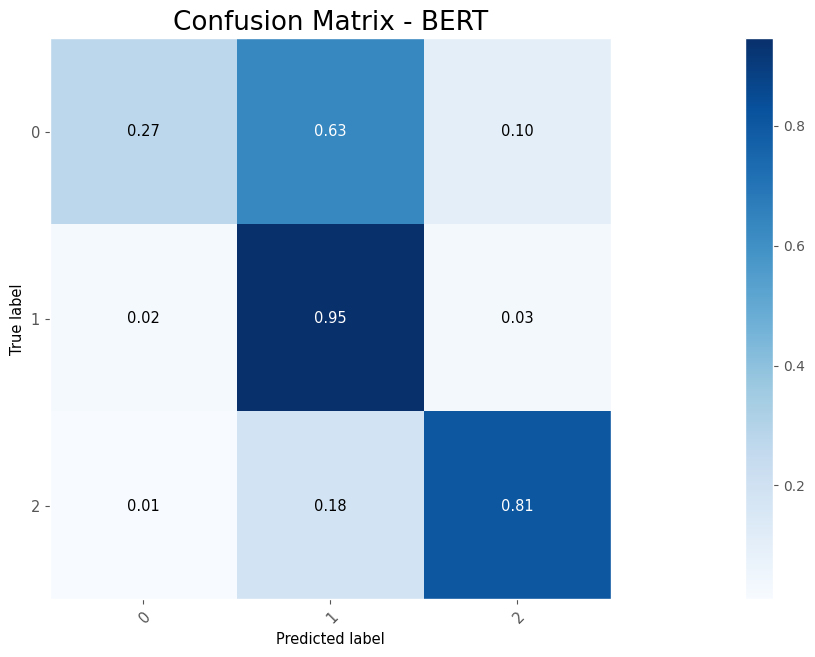

array([[0.27027027, 0.63175676, 0.09797297],
       [0.02283935, 0.94575655, 0.0314041 ],
       [0.00990099, 0.18440594, 0.80569307]])

In [23]:
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized_texts_train_bert = tokenizer_bert(list(X_train), padding=True, truncation=True, max_length=max_length, return_tensors='pt')
tokenized_texts_test_bert = tokenizer_bert(list(X_test), padding=True, truncation=True, max_length=max_length, return_tensors='pt')

# Save tokenized data to disk
torch.save(tokenized_texts_train_bert, 'tokenized_texts_train_bert.pth')  
torch.save(tokenized_texts_test_bert, 'tokenized_texts_test_bert.pth')

train_dataset_bert = TensorDataset(tokenized_texts_train_bert.input_ids, tokenized_texts_train_bert.attention_mask, labels_train)
test_dataset_bert = TensorDataset(tokenized_texts_test_bert.input_ids, tokenized_texts_test_bert.attention_mask, labels_test)

train_loader_bert = DataLoader(train_dataset_bert, batch_size=batch_size, shuffle=True)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=batch_size, shuffle=False)

model_bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3).to(device)
model_bert.resize_token_embeddings(len(tokenizer_bert))
# model_bert.load_state_dict(torch.load('bert_model.pth'))  # Load pre-trained BERT model from disk
# model_bert.eval()

optimizer_bert = AdamW(model_bert.parameters(), lr=5e-5, no_deprecation_warning=True)
tokenized_texts_train_bert = torch.load('tokenized_texts_train_bert.pth')  # Load pre-processed tokenized data from disk
tokenized_texts_test_bert = torch.load('tokenized_texts_test_bert.pth')

all_loss_bert = {'train_loss':[], 'val_loss':[]}
all_acc_bert = {'train_acc':[], 'val_acc':[]}

print("Training BERT model...")
model_bert.train()
for epoch in tqdm(range(epochs)):
    total_loss = 0
    total_correct_train = 0
    total_samples_train = 0
    for batch in train_loader_bert:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        optimizer_bert.zero_grad()
        
        outputs = model_bert(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        writer.add_scalar("Loss/train_bert", loss, epoch)
        total_loss += loss.item()

        _, predicted_train = torch.max(outputs.logits, 1)
        total_samples_train += labels.size(0)
        total_correct_train += (predicted_train == labels).sum().item()
        
        loss.backward()
        optimizer_bert.step()
    
    avg_loss = total_loss / len(train_loader_bert)
    print(f'Epoch {epoch + 1}: Average Loss: {avg_loss}')
    all_loss_bert['train_loss'].append(total_loss / len(train_loader_bert))
    all_acc_bert['train_acc'].append(total_correct_train / total_samples_train)
    model_bert.eval()
    total_val_loss = 0
    total_correct_val = 0
    total_samples_val = 0
    with torch.no_grad():
        for batch in test_loader_bert:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model_bert(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss = outputs.loss

            total_val_loss += val_loss.item()

            _, predicted_val = torch.max(outputs.logits, 1)
            total_samples_val += labels.size(0)
            total_correct_val += (predicted_val == labels).sum().item()

    all_loss_bert['val_loss'].append(total_val_loss / len(test_loader_bert))
    all_acc_bert['val_acc'].append(total_correct_val / total_samples_val)
    writer.add_scalar("Loss/val_bert", total_val_loss / len(test_loader_bert), epoch)

    torch.save(model_bert.state_dict(), 'bert_model.pth') # saving bert model
    writer.flush()
    writer.close()

print("BERT training complete.")
model_bert.eval()
predicted_labels_bert = []
true_labels_bert = []

with torch.no_grad():
    for batch in test_loader_bert:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        
        outputs = model_bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predicted_labels_bert.extend(torch.argmax(logits, axis=1).tolist())
        true_labels_bert.extend(labels.tolist())

accuracy_bert = accuracy_score(true_labels_bert, predicted_labels_bert)
print(f'BERT Accuracy: {accuracy_bert}')

plot_dict(all_loss_bert, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])
plot_dict(all_acc_bert, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'])

print("Classification Report:")
print(classification_report(true_labels_bert, predicted_labels_bert, target_names=['class 0', 'class 1', 'class 2']))

plot_confusion_matrix(y_true=true_labels_bert, y_pred=predicted_labels_bert, classes=[0, 1, 2], normalize=True, magnify=0.1, use_title="Confusion Matrix - BERT")

# Testing on some sentences

In [24]:
input_sentences = ["weather is wonderful today", "fucking bitch you are so stupid", "go back to africa nigga", "stupid autistic nigga"]

messages = ["hate speech", "offensive language", "message approved"]

preprocessed_input_sentences = clean_text(input_sentences)
preprocessed_input_sentences = remove_stopwords(preprocessed_input_sentences)
preprocessed_input_sentences = apply_stemming(preprocessed_input_sentences)
preprocessed_input_sentences = apply_lemmatization(preprocessed_input_sentences)

for input_sentence in preprocessed_input_sentences:
    print(f"Input: {input_sentence}")

    # Tokenize input for BERT
    input_ids_bert = tokenizer_bert.encode(input_sentence, return_tensors='pt').to(device)
    attention_mask_bert = torch.ones_like(input_ids_bert).to(device)

    # Generate output for BERT
    with torch.no_grad():
        outputs_bert = model_bert(input_ids_bert, attention_mask=attention_mask_bert)
        predicted_class_bert = torch.argmax(outputs_bert.logits, dim=1).item()

    print(f"BERT Response: Class {predicted_class_bert} - {messages[predicted_class_bert]}")

    # Tokenize input for GPT-2
    input_ids_gpt2 = tokenizer_gpt2.encode(input_sentence, return_tensors='pt').to(device)
    attention_mask_gpt2 = torch.ones_like(input_ids_gpt2).to(device)

    # Generate output for GPT-2
    with torch.no_grad():
        outputs_gpt2 = model_gpt2(input_ids_gpt2, attention_mask=attention_mask_gpt2)
        predicted_class_gpt2 = torch.argmax(outputs_gpt2.logits, dim=1).item()

    print(f"GPT-2 Response: Class {predicted_class_gpt2} - {messages[predicted_class_gpt2]}\n")

    # Multi-agent system: GPT-2 and BERT cooperate to guarantee a correct solution, based on their accuracy
    predicted_class_coop = (predicted_class_bert * accuracy_bert + predicted_class_gpt2 * accuracy_gpt2) / (accuracy_gpt2 + accuracy_bert)
    print(f"Cooperative result: Class {predicted_class_coop:.3f} - {messages[round(predicted_class_coop)]}\n")



Input: weather wonder today
BERT Response: Class 2 - message approved
GPT-2 Response: Class 2 - message approved

Cooperative result: Class 2.000 - message approved

Input: fuck bitch stupid
BERT Response: Class 1 - offensive language
GPT-2 Response: Class 1 - offensive language

Cooperative result: Class 1.000 - offensive language

Input: go back africa nigga
BERT Response: Class 1 - offensive language
GPT-2 Response: Class 0 - hate speech

Cooperative result: Class 0.503 - offensive language

Input: stupid autist nigga
BERT Response: Class 0 - hate speech
GPT-2 Response: Class 0 - hate speech

Cooperative result: Class 0.000 - hate speech



# Plot

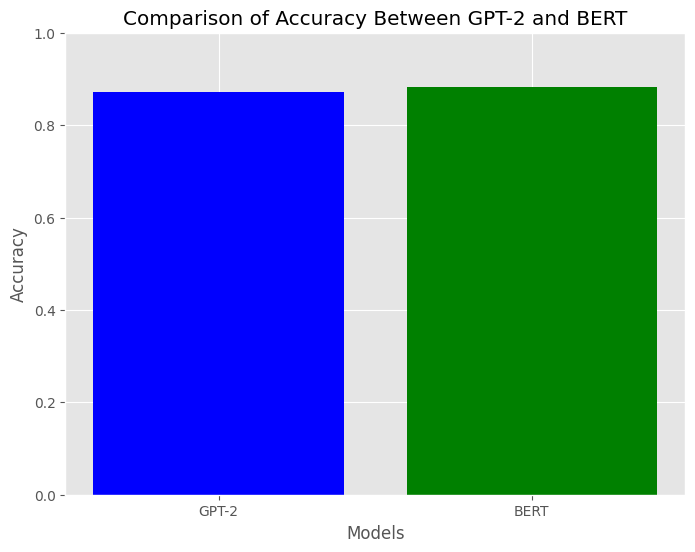

In [25]:
models = ['GPT-2', 'BERT']
accuracies = [accuracy_gpt2, accuracy_bert]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy Between GPT-2 and BERT')
plt.ylim(0, 1)  # Set the y-axis limit from 0 to 1
plt.show()